<a href="https://colab.research.google.com/github/yassine-mathlouthi/job-classification-model/blob/main/resume_classification_using_bertpart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the necessary libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install wget

In [ ]:
!pip install tensorflow==2.10.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yassi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [ ]:
df = pd.read_csv("./UpdatedResumeDataSet.csv")
df


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## Exploratory Data Analysis

In [ ]:
df.shape

(962, 2)

In [ ]:
df.info()
missing_values = df.isnull().sum()
print("les valeurs manquantes :\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Category    962 non-null    object
 1   Resume      962 non-null    object
 2   resume_len  962 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.7+ KB
les valeurs manquantes :
 Category      0
Resume        0
resume_len    0
dtype: int64


In [ ]:
df.isna().sum()

Category    0
Resume      0
dtype: int64

In [ ]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

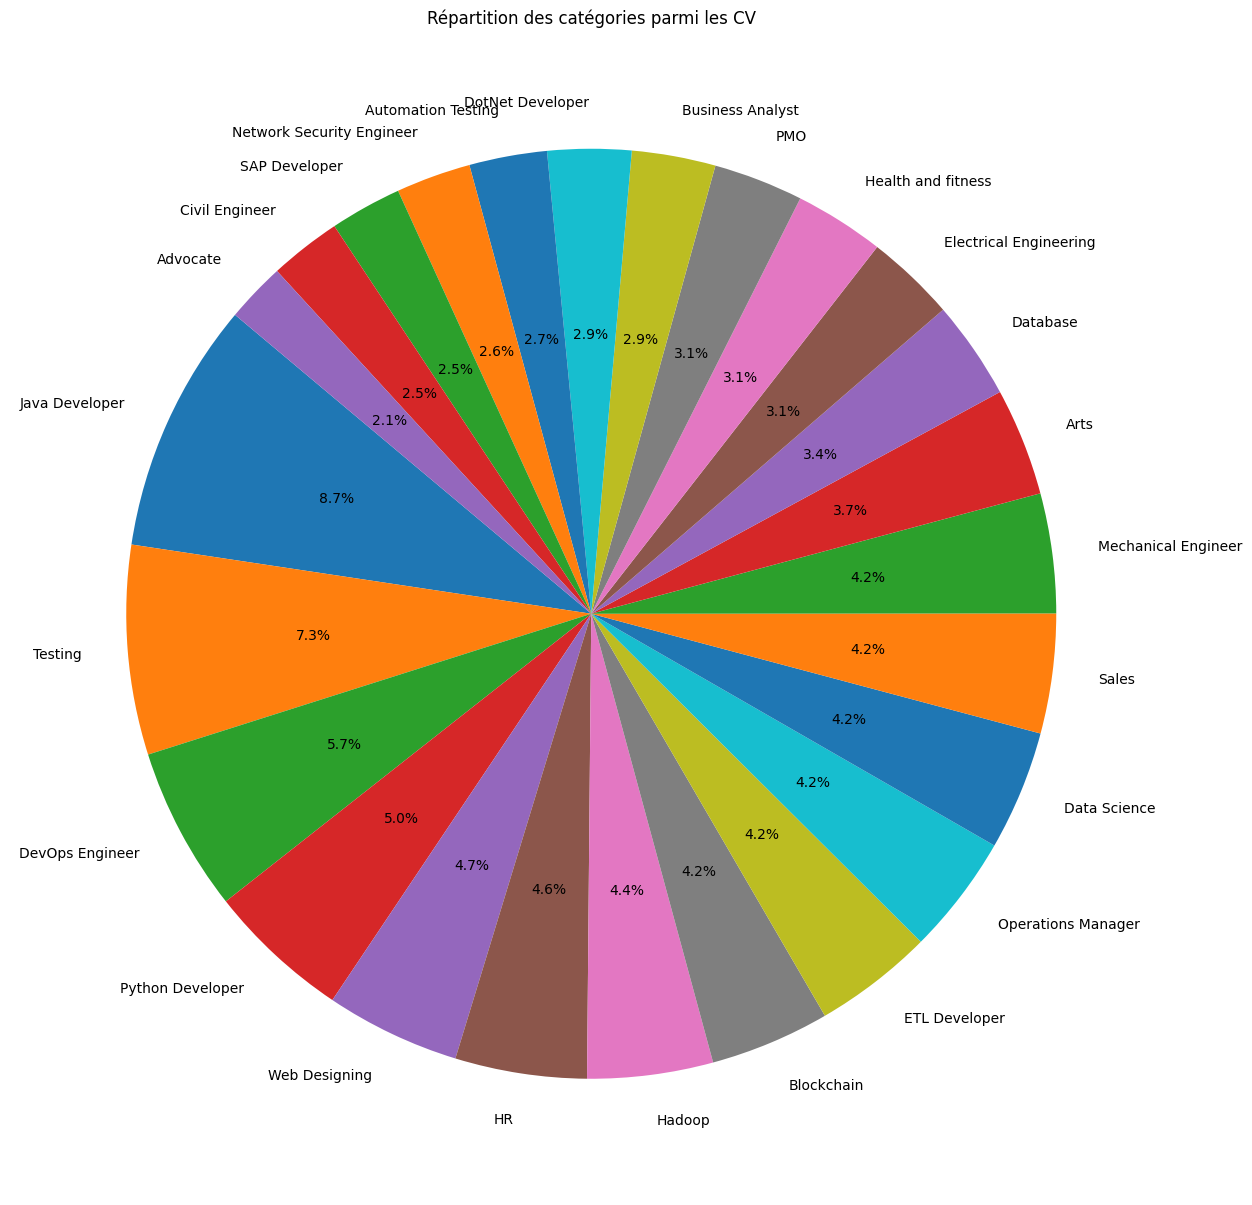

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création d'un graphique en secteurs
plt.figure(figsize=(15, 20))
df['Category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Répartition des catégories parmi les CV')
plt.ylabel('')

# Affichage du graphique
plt.show()


In [ ]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 25


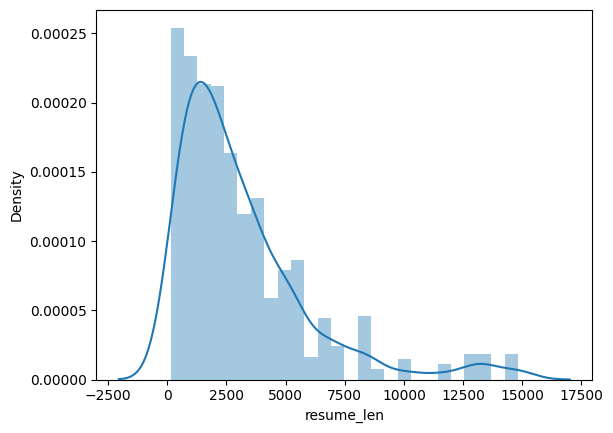

In [ ]:
df['resume_len'] = df.Resume.apply(len)
sns.distplot(df.resume_len);

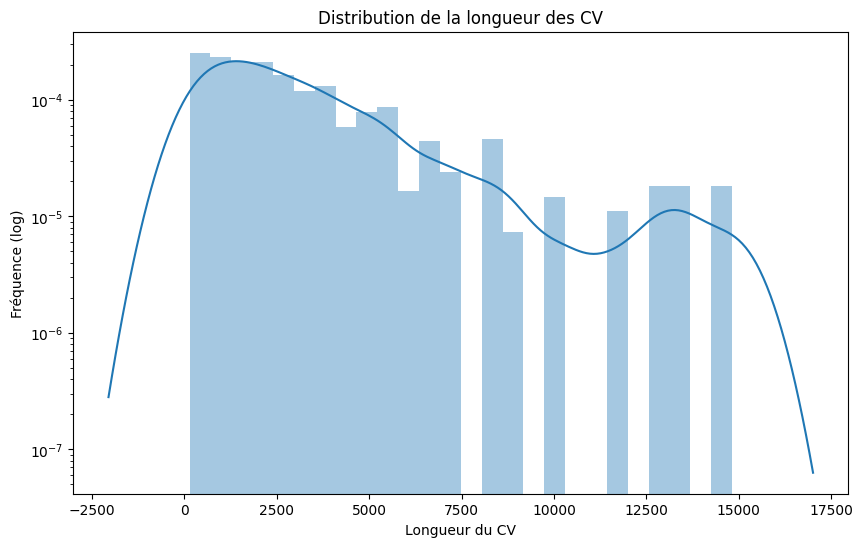

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Tracé de la distribution avec échelle logarithmique sur l'axe y
df['resume_len'] = df.Resume.apply(len)
plt.figure(figsize=(10, 6))
sns.distplot(df.resume_len)
plt.yscale('log')  # Utilisation de l'échelle logarithmique sur l'axe y
plt.ylabel('Fréquence (log)')
plt.xlabel('Longueur du CV')
plt.title('Distribution de la longueur des CV')
plt.show()


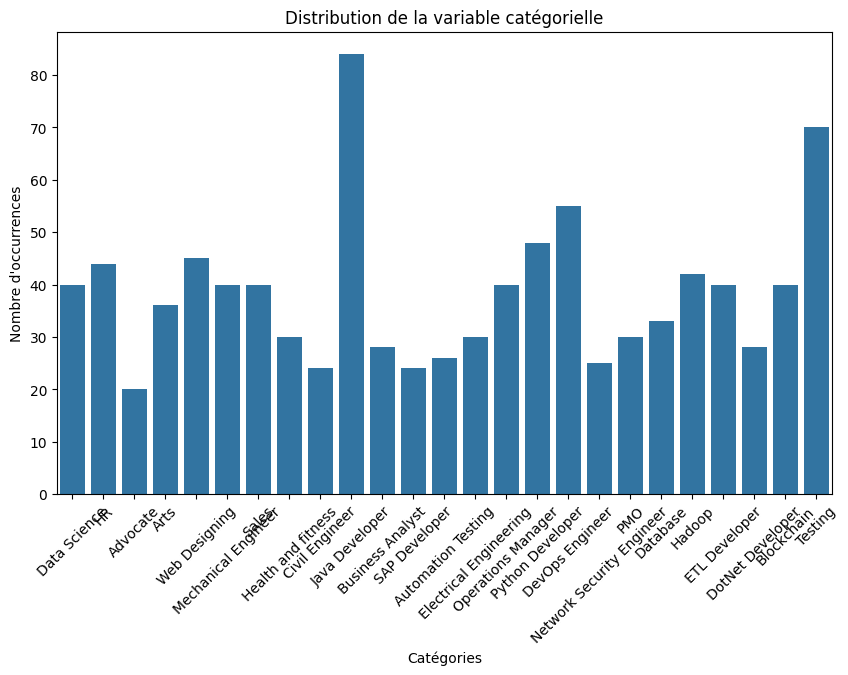

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category')
plt.title('Distribution de la variable catégorielle')
plt.xlabel('Catégories')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.show()

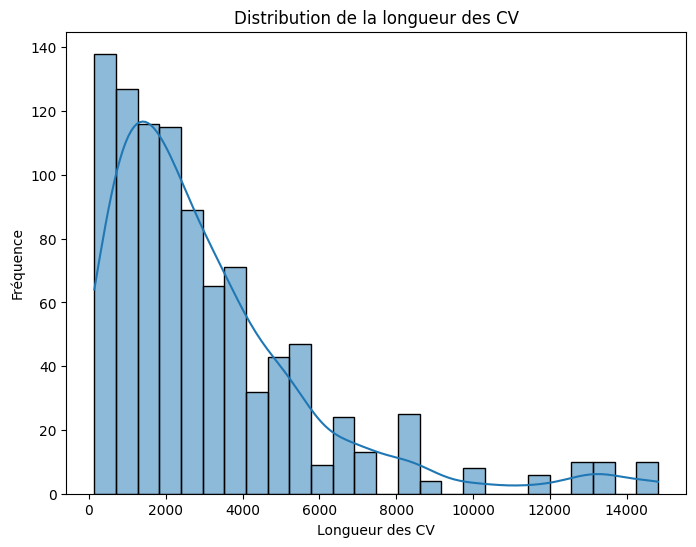

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['resume_len'], kde=True)
plt.title('Distribution de la longueur des CV')
plt.xlabel('Longueur des CV')
plt.ylabel('Fréquence')
plt.show()

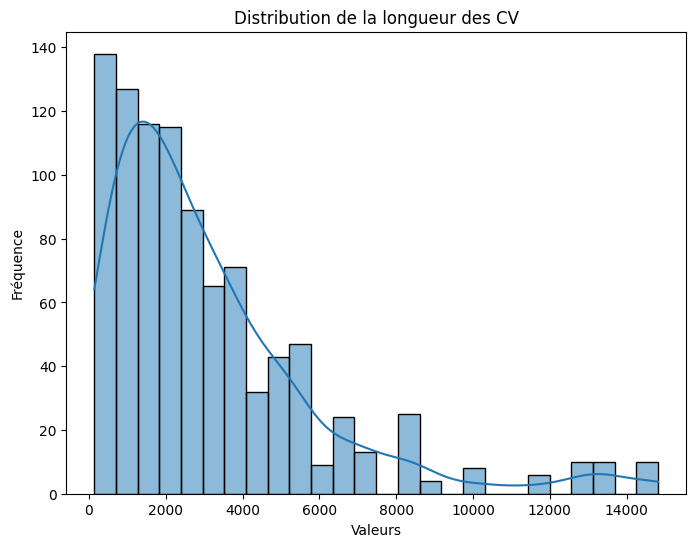

In [ ]:
df['resume_len'] = df.Resume.apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['resume_len'], kde=True)
plt.title('Distribution de la longueur des CV')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

Category      0
Resume        0
resume_len    0
dtype: int64


In [ ]:
df.describe()

,resume_len
count,962.000000
mean,3160.364865
std,2886.528521
min,142.000000
25%,1217.250000
50%,2355.000000
75%,4073.750000
max,14816.000000


In [ ]:
max_resume_len = 200

## Encoding the target labels i.e. all available jobs

In [ ]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'Data Science': 0,
 'HR': 1,
 'Advocate': 2,
 'Arts': 3,
 'Web Designing': 4,
 'Mechanical Engineer': 5,
 'Sales': 6,
 'Health and fitness': 7,
 'Civil Engineer': 8,
 'Java Developer': 9,
 'Business Analyst': 10,
 'SAP Developer': 11,
 'Automation Testing': 12,
 'Electrical Engineering': 13,
 'Operations Manager': 14,
 'Python Developer': 15,
 'DevOps Engineer': 16,
 'Network Security Engineer': 17,
 'PMO': 18,
 'Database': 19,
 'Hadoop': 20,
 'ETL Developer': 21,
 'DotNet Developer': 22,
 'Blockchain': 23,
 'Testing': 24}

In [ ]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)


## Text Preprocessing

In [ ]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [ ]:
preprocessed_df = text_preprocess(df,'Resume')
preprocessed_df

,Category,Resume,resume_len
0,0,skills programming languages python pandas num...,4786
1,0,education details may may b e uitrgpv data sci...,1268
2,0,areas interest deep learning control system de...,1871
3,0,skills r python sap hana tableau sap hana sql ...,6995
4,0,education details mca ymcaust faridabad haryan...,452
...,...,...,...
957,24,computer skills proficient ms office word basi...,2130
958,24,willingness accept challenges positive thinkin...,2306
959,24,personal skills quick learner eagerness learn ...,3319
960,24,computer skills software knowledge mspower poi...,767


## Downloading the pretrained tokenizer and DistilBert model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the preprocessed dataset into training and test sets

In [ ]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101)

## Text Tokenization

In [ ]:
X_train = tokenizer(text=train_df.Resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

NameError: name 'tokenizer' is not defined

## Defining the model architecture

In [ ]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0]

output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=25,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

In [ ]:
model.layers[2].trainable = True

## Visualizing the model architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66962700   ['input_ids[0][0]',              
 assification_1 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 12),                                                
                                 hidden_states=None                                           

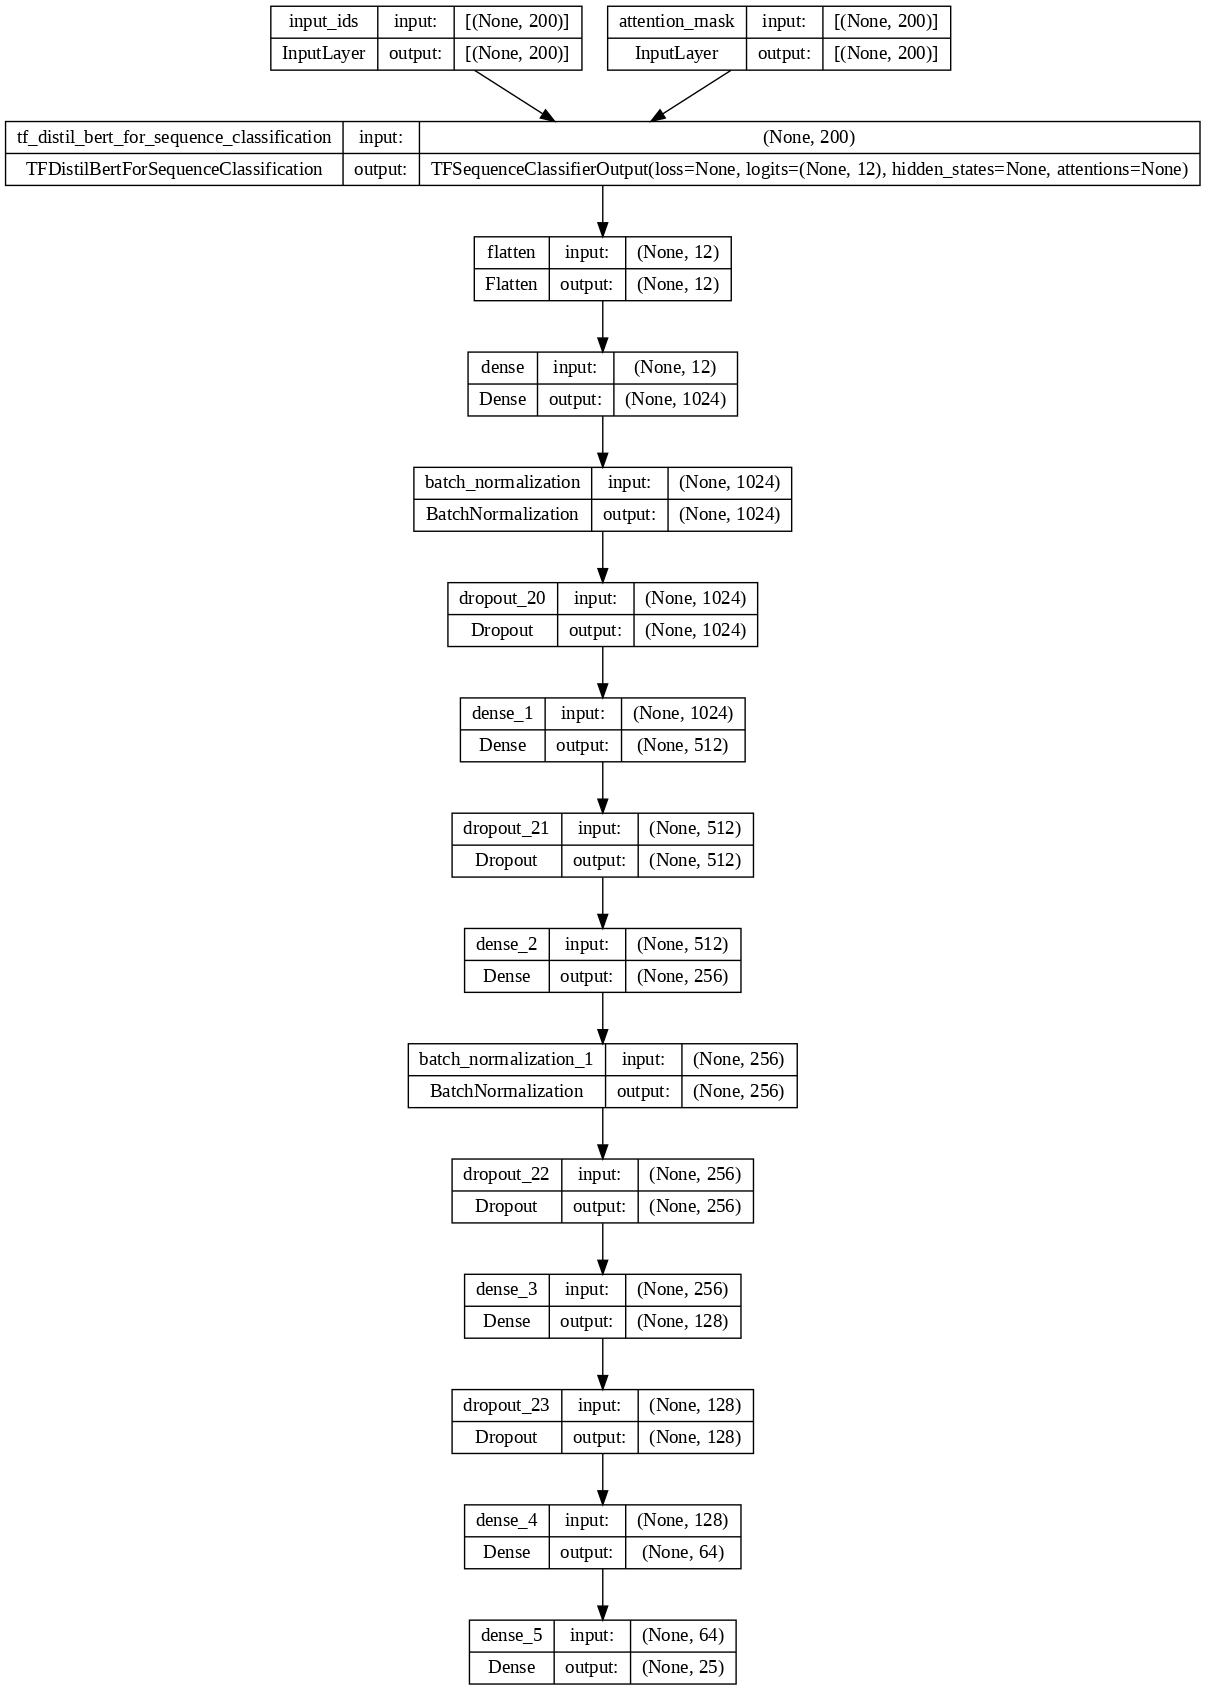

In [ ]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

## Compiling the model

In [ ]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

## Training the fine-tuned Distil-Bert model

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.Category,
             epochs=500,
             batch_size=32,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category))

Epoch 1/500
22/22 [==============================] - ETA: 0s - loss: 3.6916 - balanced_accuracy: 0.0446 
Epoch 1: val_balanced_accuracy improved from -inf to 0.07266, saving model to resume_parser.h5
22/22 [==============================] - 1007s 45s/step - loss: 3.6916 - balanced_accuracy: 0.0446 - val_loss: 3.2057 - val_balanced_accuracy: 0.0727
Epoch 2/500
22/22 [==============================] - ETA: 0s - loss: 3.5388 - balanced_accuracy: 0.0475 
Epoch 2: val_balanced_accuracy improved from 0.07266 to 0.07958, saving model to resume_parser.h5
22/22 [==============================] - 980s 45s/step - loss: 3.5388 - balanced_accuracy: 0.0475 - val_loss: 3.2096 - val_balanced_accuracy: 0.0796
Epoch 3/500
22/22 [==============================] - ETA: 0s - loss: 3.4780 - balanced_accuracy: 0.0728 
Epoch 3: val_balanced_accuracy improved from 0.07958 to 0.10381, saving model to resume_parser.h5
22/22 [==============================] - 989s 45s/step - loss: 3.4780 - balanced_accuracy: 0.07

## Visualizing the model performance

In [ ]:
import tensorflow as tf
from keras.models import load_model
from transformers import TFDistilBertForSequenceClassification

# Define custom objects for loading the model
custom_objects = {'TFDistilBertForSequenceClassification': TFDistilBertForSequenceClassification}

# Load the model with custom object scope
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('resume_parser.h5')

# Now you can use the loaded model for inference or further training


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming you have X_test and y_test ready for evaluation
# Assuming your model.predict() gives you probabilities for each class

# Get the probabilities for each class
model_probs = model.predict(X_test)

# Binarize the labels
y_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC curve for each class
fpr_model = dict()
tpr_model = dict()
roc_auc_model = dict()
for i in range(len(np.unique(y_test))):
    fpr_model[i], tpr_model[i], _ = roc_curve(y_bin[:, i], model_probs[:, i])
    roc_auc_model[i] = auc(fpr_model[i], tpr_model[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr_model[i], tpr_model[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_model[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Your Model (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have compiled and trained your model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
es = EarlyStopping(monitor='val_loss', patience=250, verbose=1, mode='min', restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Train the model
history = model.fit(
    x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y=train_df.Category,
    epochs=500,
    batch_size=32,
    callbacks=[es, mc],
    validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, test_df.Category)
)


# Plot the training history
plt.plot(history.history['loss'], 'r', label='train loss')
plt.plot(history.history['val_loss'], 'b', label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/500


KeyboardInterrupt: 

In [ ]:
plt.plot(model.history['loss'],'r',label='train loss')
plt.plot(model.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

TypeError: 'NoneType' object is not subscriptable

In [ ]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Categorical Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Model Evaluation

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category)
print("Test Sparse Categorical Crossentropy Loss:", loss)
print("Test Balanced Categorical Accuracy:", acc)

NameError: name 'X_test' is not defined

In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

 3/10 [========>.....................] - ETA: 1:14

KeyboardInterrupt: 

10/10 [==============================] - 60s 6s/step


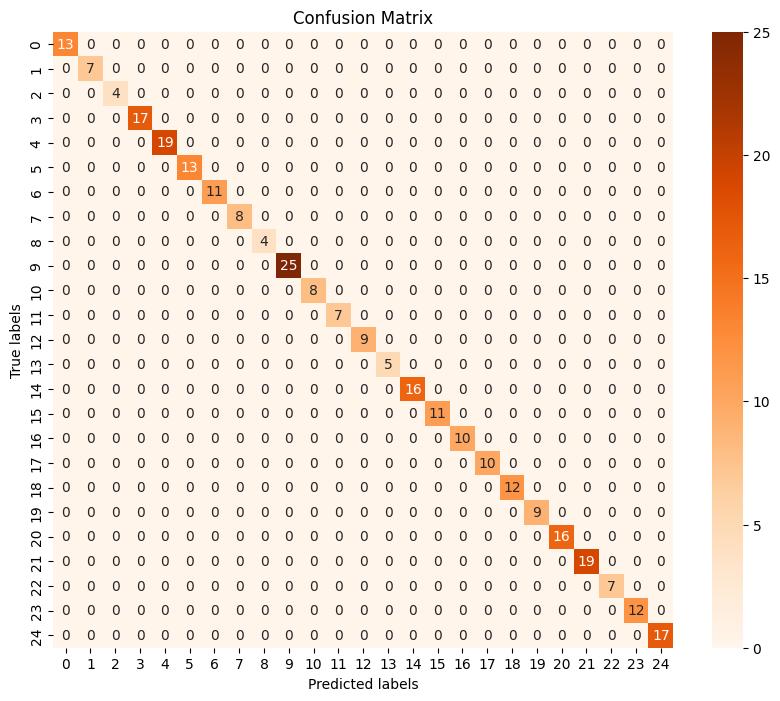

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        25
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00        16
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        10
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})

# Convert predictions to class labels
test_predictions = [np.argmax(pred) for pred in test_predictions]

# Compute confusion matrix
conf_matrix = confusion_matrix(test_df.Category, test_predictions)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_df.Category, test_predictions))


This is absolutely incredible! The fine-tuned Distil-Bert model has produced an astonishing accuracy score of more than 99% on the test set.